
Stimuli:


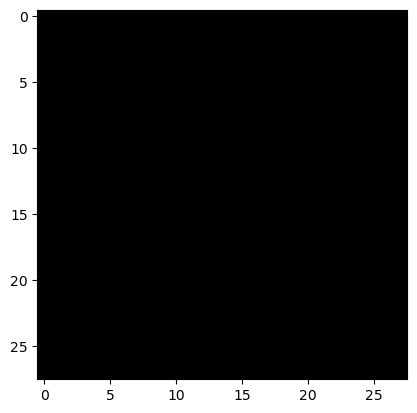

Excitatory cell e1 spike count: 1, and weight distribution after 0 seconds:


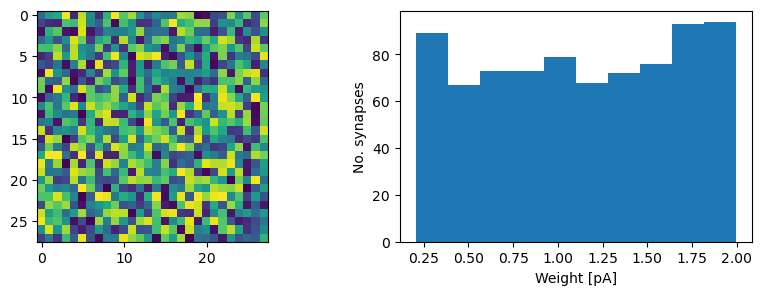

Excitatory cell e2 spike count: 6, and weight distribution after 0 seconds:


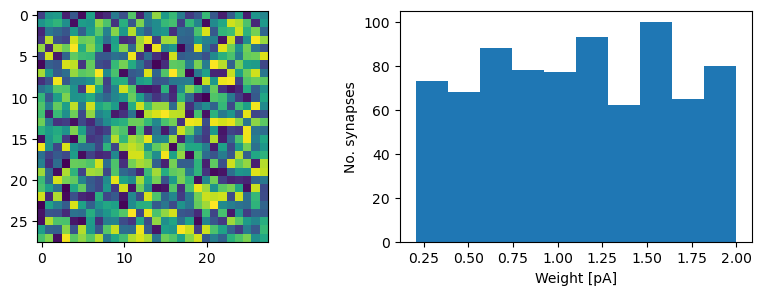

IndexError: list index out of range

In [26]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from __future__ import print_function   # Python 2.X support for print function, not needed in Python 3.X
from IPython.display import clear_output
#from IPython.core.debugger import set_trace # Activates debugging features

def rasterplot(ax, x, y, x_label, y_label):
# Function used to plot spike times
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))


def lif_neuron(I_inject, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3):
    # LIF neuron with a constant injection current
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'E_L'     : E_L,                       # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_inj'   : I_inject,                  # Injection current [Ampere]
    }

def lif_syn_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3, I_inject=0, tau_syn=50e-3):
    # LIF neuron with dynamic synapses
    n = lif_neuron(I_inject, E_L, u_reset, u_thres, R, tau_m)
    n['tau_syn'] = tau_syn                     # Synapse time constant [second] (can also be an array)
    n['I_syn']   = np.zeros(num_synapses)      # Postsynaptic currents [Ampere]
    n['w_syn']   = np.zeros(num_synapses)      # Synaptic weights [Ampere]
    n['type']    = 'lif_syn'
    return n

def lif_stdp_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3, I_inject=0,
                    tau_syn=50e-3, tau_pls=20e-3, tau_mns=20e-3, w_max=1e-9, w_min=1e-12, gamma=1):
    # LIF neuron with dynamic synapses and pair-based STDP
    n = lif_syn_neuron(num_synapses, E_L, u_reset, u_thres, R, tau_m, I_inject, tau_syn)
    n['x_pre']   = np.zeros(num_synapses)      # STDP trace of presynaptic spikes
    n['y_pst']   = 0                           # STDP trace of postsynaptic spikes (scalar, one neuron)
    n['tau_pls'] = tau_pls                     # STDP trace time constant [second] (can also be an array)
    n['tau_mns'] = tau_mns                     # STDP trace time constant [second] (can also be an array)
    n['w_max']   = w_max                       # Largest allowed value of synapse conductance
    n['w_min']   = w_min                       # Lowest allowed value of synapse conductance
    n['gamma']   = gamma                       # Learning rate parameter with soft bounds (w_min,w_max)
    n['type']    = 'lif_stdp'
    return n

def integrate(dt, t, neurons):
    # Integrate the membrane potential, postsynaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif':
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*n['I_inj']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] in ['lif_syn','lif_stdp']:
            # Integrate array of postsynaptic currents, one current for each synapse
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*(n['I_inj']+sum(n['I_syn']))) / n['tau_m']
            n['u'] += dt*dudt
            # Integrate local traces for pair-based plasticity
            if n['type'] == 'lif_stdp':
                n['x_pre'] -= dt*np.divide(n['x_pre'], n['tau_pls'])       # Eq 19.12
                n['y_pst'] -= dt*np.divide(n['y_pst'], n['tau_mns'])       # Eq 19.13
            
def spikegen(dt, t, neurons):
    # Implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif','lif_syn','lif_stdp']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'poisson':
            if np.random.rand() < dt*n['frequency']:
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
                
    return spikes

def update(dt, t, neurons, connections):
    # Update the state of a spiking neural network.
    # Refer to Exercise 3 for a reminder about how to set up connections between neurons.
    integrate(dt, t, neurons)
    spikes = spikegen(dt, t, neurons)

    # Update weights and STDP trace for each postsynaptic spike
    for spike in spikes:
        n = neurons[spike]
        if n['type'] in ['lif_stdp']:
            n['y_pst'] += 1                                         # Eq 19.13
            for i,w in enumerate(n['w_syn']):
                if w > 0:                                           # Excitatory synapses
                    Aplus = n['gamma']*(n['w_max'] - n['w_syn'][i]) # Eq 19.4
                    n['w_syn'][i] += dt*Aplus*n['x_pre'][i]         # Eq 19.14
    
    # Update synapse currents, weights and STDP traces for each presynaptic spike
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                n = neurons[post]
                
                if n['type'] not in ['lif_syn', 'lif_stdp']:
                    print('Error: Spike sent to neuron type without synapses')
                
                # Update synapse currents
                if n['type'] in ['lif_syn','lif_stdp']:
                    n['I_syn'][syn] += n['w_syn'][syn]
                    
                # Update STDP trace and weight
                if n['type'] in ['lif_stdp']:
                    n['x_pre'][syn] += 1                                   # Eq 19.12
                    if n['w_syn'][syn] > 0:                                # Excitatory synapses
                        Aminus = n['gamma']*(n['w_min'] - n['w_syn'][syn]) # Eq 19.4
                        n['w_syn'][syn] += dt*Aminus*n['y_pst']            # Eq 19.14
    
    return spikes

def set_input_frequencies(neurons, image):
# Convert pixel intensities to spikerates of random (Poisson) neurons
    for i in range(N_pixls):
        for j in range(N_pixls):
            neurons[i*N_pixls+j]['frequency'] = 5 + 55*image[i][j] # 5-60 Hz

def reset_input_frequencies(neurons):
# Reset frequencies of input neurons to 0 Hz
    for i in range(N_pixls):
        for j in range(N_pixls):
            neurons[i*N_pixls+j]['frequency'] = 0
            
def plot_digit(plt, data):
# Display MNIST images
    data = data.view(28,28)
    plt.imshow(data, cmap='gray')

    
def spikerate_filter(spikerate, spikecount, simtime, alpha):
# Low-pass filter for estimation of spikerate
    if spikerate > 0:
        spikerate = alpha*spikerate + (1-alpha)*spikecount/simtime
    else:
        spikerate = spikecount/simtime
    return spikerate

def plot_neuron_weights(n):
# Plot the input weights of an excitatory neuron (with STDP synapses)
    plt.rcParams['figure.figsize'] = [10, 3]
    fig,(ax1,ax2) = plt.subplots(1,2)
    img = np.zeros((N_pixls,N_pixls))
    for i in range(N_pixls):
        for j in range(N_pixls):
            img[i][j] = n['w_syn'][i*N_pixls+j]/1e-12
    ax1.imshow(img, cmap='viridis')
    ax2.hist(np.hstack(img))
    ax2.set_xlabel('Weight [pA]')
    ax2.set_ylabel('No. synapses')
    plt.show()

# Extract 10 training samples for two classes of digits

rightVid = loadDataset("right")
leftVid = loadDataset("left")




def poisson_neuron(spike_frequency):
    # Random spike generator with Poisson distributed spike time intervals, see Section 7.2.1 in the book
    return {
        'type'      : 'poisson',
        'frequency' : spike_frequency          # Average spiking frequency
    }

N_pixls = 28
N_input = N_pixls*N_pixls

neurons = []
connections = []

# Create input neurons, frequencies will be set later
for i in range(N_input):
    neurons.append(poisson_neuron(0))
    
# Create two excitatory neurons
e1 = lif_stdp_neuron(N_input+1, w_min=0, w_max=10e-12)
e2 = lif_stdp_neuron(N_input+1, w_min=0, w_max=10e-12)
neurons.append(e1)
neurons.append(e2)
I_e1 = N_input
I_e2 = N_input+1

# Define excitatory STDP synapses for the inputs
for j in range(N_input):
    e1['w_syn'][j] = 2e-12*(0.1 + 0.9*np.random.rand())
    e2['w_syn'][j] = 2e-12*(0.1 + 0.9*np.random.rand())
    connections.append([I_e1,j,j]) # [post,syn,pre], see Exercise 3 for details
    connections.append([I_e2,j,j]) # [post,syn,pre]

# Lateral inhibition (neglecting Dale's law to simplify the exercise)
I_inhib = N_input
e1['w_syn'][I_inhib] = -1e-12
e2['w_syn'][I_inhib] = -1e-12
connections.append([I_e1,I_inhib,I_e2])
connections.append([I_e2,I_inhib,I_e1])

# Reset the simulation time
t = 0
dt = 5e-4
simtime = 0.35
rsttime = 0.15

# Reset spikerate variables
e1_spikerate = -1
e2_spikerate = -1

# Speed up learning a bit
e1['gamma'] = 5
e2['gamma'] = 5




for iterations in range(50): # Training iterations

    # Start time
    t0 = t
    
    # Spike counts of e1 and e2
    e1_count = 0
    e2_count = 0
    
    # Sample a different digit every second iteration
    stimuli = []
    if iterations % 2 == 0:
        
        vid = rightVid[int(len(rightVid)*np.random.rand())]
        ##############################################################################
        #INSERT SUPERVISION SIGNAL HERE, INHIBIT ONE OF THE TWO STDP NEURONS
        e1['w_syn'][I_inhib] = -200e-12
        e2['w_syn'][I_inhib] = 0
        ##############################################################################
    else:
        vid = leftVid[int(len(rightVid)*np.random.rand())]
        ##############################################################################
        # INSERT SUPERVISION SIGNAL HERE, INHIBIT ONE OF THE TWO STDP NEURONS
        e1['w_syn'][I_inhib] = 0
        e2['w_syn'][I_inhib] = -300e-12
        ##############################################################################
    
    stimuli = vid[0][0]
    frameCount = 1
    set_input_frequencies(neurons, stimuli)
    
    # Simulate the network
    while t < t0+simtime:
        
        if t0+simtime > 1/60*frameCount:
            stimuli = vid[frameCount][0]
            set_input_frequencies(neurons, stimuli)
            frameCount += 1
        # change frame
        
        # Update network, including STDP
        spikes = update(dt, t, neurons, connections)
        
        # Count number of spikes from e1 and e2
        e1_count += spikes.count(I_e1)
        e2_count += spikes.count(I_e2)
        
        # Timestep completed
        t += dt
        print('\r t = %fs (%d%%)' % (t, 100*(t-t0)/(simtime+rsttime)), end='')

    # Let neurons and synapses rest before the next stimuli 
    reset_input_frequencies(neurons)
    while t < t0+simtime+rsttime:
        spikes = update(dt, t, neurons, connections)
        e1_count += spikes.count(I_e1)
        e2_count += spikes.count(I_e2)
        t += dt
        print('\r t = %fs (%d%%)' % (t, 100*(t-t0)/(simtime+rsttime)), end='')

    # Refresh the plots
    clear_output()
    print('\nStimuli:')
    plot_digit(plt,stimuli)
    plt.show()
    print('Excitatory cell e1 spike count: %d, and weight distribution after %d seconds:' % (e1_count,t))
    plot_neuron_weights(e1)
    print('Excitatory cell e2 spike count: %d, and weight distribution after %d seconds:' % (e2_count,t))
    plot_neuron_weights(e2)
    plt.show()

In [25]:
import os
from pathlib import Path
import numpy as np
import torch
    
def getData(file):
    f = open(file, "r")
    fileContent = f.readlines()
    data = []
    for frame in fileContent:
        newFrame = frame.replace("\n","")
        newFrame = newFrame.split(",")
        newFrame = [int(i) for i in newFrame]
        newFrame = listToTensor(newFrame, 28)
        data.append(newFrame)
    return data
            
def loadDataset(dataset):
    if dataset.lower() == "right":
        dir = Path('C:/Users/marcu/Downloads/D7046E_SSN_BETA/data/Right')
    elif dataset.lower() == "left":
        dir = Path('C:/Users/marcu/Downloads/D7046E_SSN_BETA/data/Left')
    else:
        print("no such dataset")
        return;
    Data = []
    for child in dir.iterdir():
        Data.append(getData(child))
        
    return(Data)
    
            
            
            
def listToTensor(lst, dim):
    
    chunked_list = [[list(array) for array in np.array_split(np.array(lst), dim)]]
    lst = torch.FloatTensor(chunked_list)
    return lst
    
print(loadDataset("right")[0][10])

        

tensor([[[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,

In [3]:
import numpy as np
import cv2
import csv

def motion_detector(video_file=0, compress_to_size=(100,100), show_video=False, frame_step=2, max_frames=np.inf, output_file=""):
  
  frame_count = 0
  previous_frame = None
  cap = cv2.VideoCapture(video_file)
  preprocessed_file = []
  
  while True:
    frame_count += 1

    # 1. Load image; convert to RGB
    ret, frame = cap.read()

    # If video check when end or ESC is hit
    if frame is None or cv2.waitKey(30) == 27 or frame_count > max_frames:
      print(frame_count - 1)
      cap.release()
      
      if show_video:
        cv2.destroyAllWindows()

      # if a output file is given save the file
      if(output_file != ""):
        f = open(output_file, 'w')
        for item in preprocessed_file:
            f.write(','.join([str(x) for x in item]) + '\n')
        f.close()

      break

    frame = np.flip(frame, axis=1)
    frame = cv2.resize(frame, compress_to_size)
    frame = cv2.cvtColor(src=frame, code=cv2.COLOR_BGR2RGB)

    
    if ((frame_count % frame_step) == 0):

      # 2. Prepare image; grayscale and blur
      prepared_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      prepared_frame = cv2.GaussianBlur(src=prepared_frame, ksize=(5,5), sigmaX=0)
      
      # 3. Set previous frame and continue if there is None
      if (previous_frame is None):
        # First frame; there is no previous one yet
        previous_frame = prepared_frame
        continue
      
      # calculate difference and update previous frame
      diff_frame = cv2.absdiff(src1=previous_frame, src2=prepared_frame)
      previous_frame = prepared_frame

      # 4. Dilute the image a bit to make differences more seeable; more suitable for contour detection
      # kernel = np.ones((5, 5))
      # diff_frame = cv2.dilate(diff_frame, kernel, 1)

      # 5. Only take different areas that are different enough (>20 / 255)
      thresh_frame = cv2.threshold(src=diff_frame, thresh=20, maxval=255, type=cv2.THRESH_BINARY)[1]

      # Save every frame
      preprocessed_file.append((thresh_frame.flatten()/255).astype(int))

      if(show_video):
        both_frame = np.concatenate((prepared_frame, thresh_frame), axis=1)
        cv2.imshow('webcam', both_frame)



In [7]:
motion_detector(output_file="test", show_video=True, max_frames=50, compress_to_size=(28, 28))

50
